# Predicting Road Accident Risk
## Playground Series - Season 5, Episode 10 - Kaggle competition
https://www.kaggle.com/competitions/playground-series-s5e10
### Solution by Maria Levkovets

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabtransformertf.utils.preprocessing import df_to_dataset, build_categorical_prep
from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from sklearn.model_selection import train_test_split

# EDA part

In [3]:
#load data 

train_df = pd.read_csv('/Users/malev41/Desktop/NN/kaggle/road_accidents/data/train.csv')

In [5]:
train_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [19]:
train_df.isnull().sum()

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

My dataset contains both categorical and numerical and boolean type features


In [20]:
train_df.nunique()

id                        517754
road_type                      3
num_lanes                      4
curvature                    261
speed_limit                    5
lighting                       3
weather                        3
road_signs_present             2
public_road                    2
time_of_day                    3
holiday                        2
school_season                  2
num_reported_accidents         8
accident_risk                 98
dtype: int64

In [21]:
print('Unique road types:', train_df['road_type'].unique())
print('Unique lightning conditions:', train_df['lighting'].unique())
print('Unique weather conditions:', train_df['weather'].unique())
print('Unique time of days:', train_df['time_of_day'].unique())


Unique road types: ['urban' 'rural' 'highway']
Unique lightning conditions: ['daylight' 'dim' 'night']
Unique weather conditions: ['rainy' 'clear' 'foggy']
Unique time of days: ['afternoon' 'evening' 'morning']


In [22]:
train_df.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849974,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


## Univariate analysis

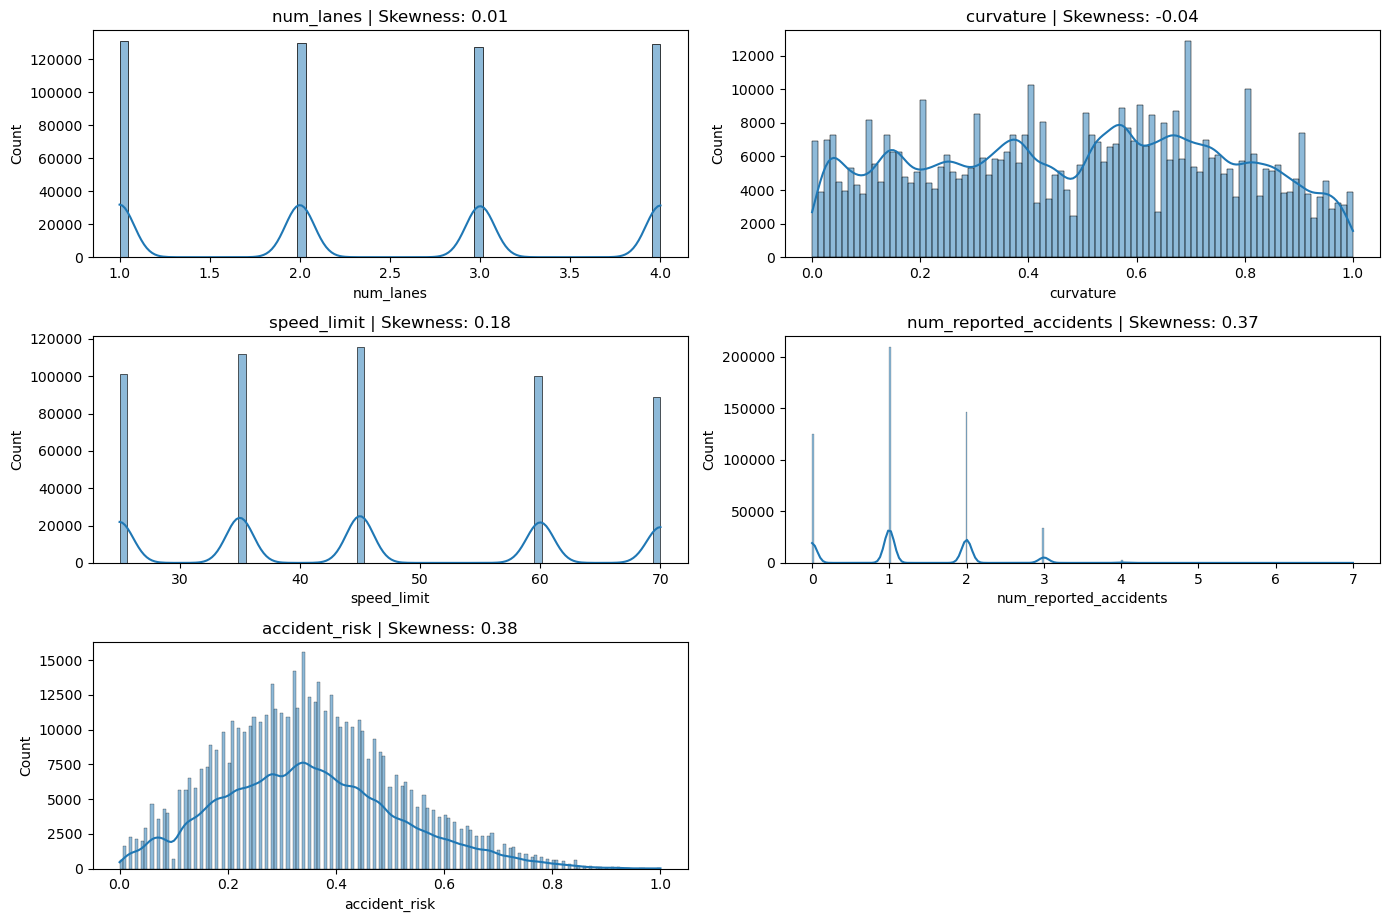

In [27]:
numerical_columns = train_df.select_dtypes(include=["int64", "float64"]).columns[1:]

plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(train_df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(train_df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

Most of my numerical features are count data. Since I will use the FT-Transformer, I will not apply any transformation to these features, as the FT-Transformer can handle skewness.
The curvature feature is continuous, with values ranging between 0 and 1 and skewness close to 0, so no transformation is needed.


## Encoding categorical features

In [34]:
train_encoded = pd.get_dummies(train_df, drop_first=False, dtype=int)

In [35]:
train_encoded.head()

,id,num_lanes,curvature,speed_limit,road_signs_present,public_road,holiday,school_season,num_reported_accidents,accident_risk,...,road_type_urban,lighting_daylight,lighting_dim,lighting_night,weather_clear,weather_foggy,weather_rainy,time_of_day_afternoon,time_of_day_evening,time_of_day_morning
0,0,2,0.06,35,False,True,False,True,1,0.13,...,1,1,0,0,0,0,1,1,0,0
1,1,4,0.99,35,True,False,True,True,0,0.35,...,1,1,0,0,1,0,0,0,1,0
2,2,4,0.63,70,False,True,True,False,2,0.30,...,0,0,1,0,1,0,0,0,0,1
3,3,4,0.07,35,True,True,False,False,1,0.21,...,0,0,1,0,0,0,1,0,0,1
4,4,1,0.58,60,False,False,True,False,1,0.56,...,0,1,0,0,0,1,0,0,1,0


## Bivariate analysis

<Figure size 1000x600 with 0 Axes>

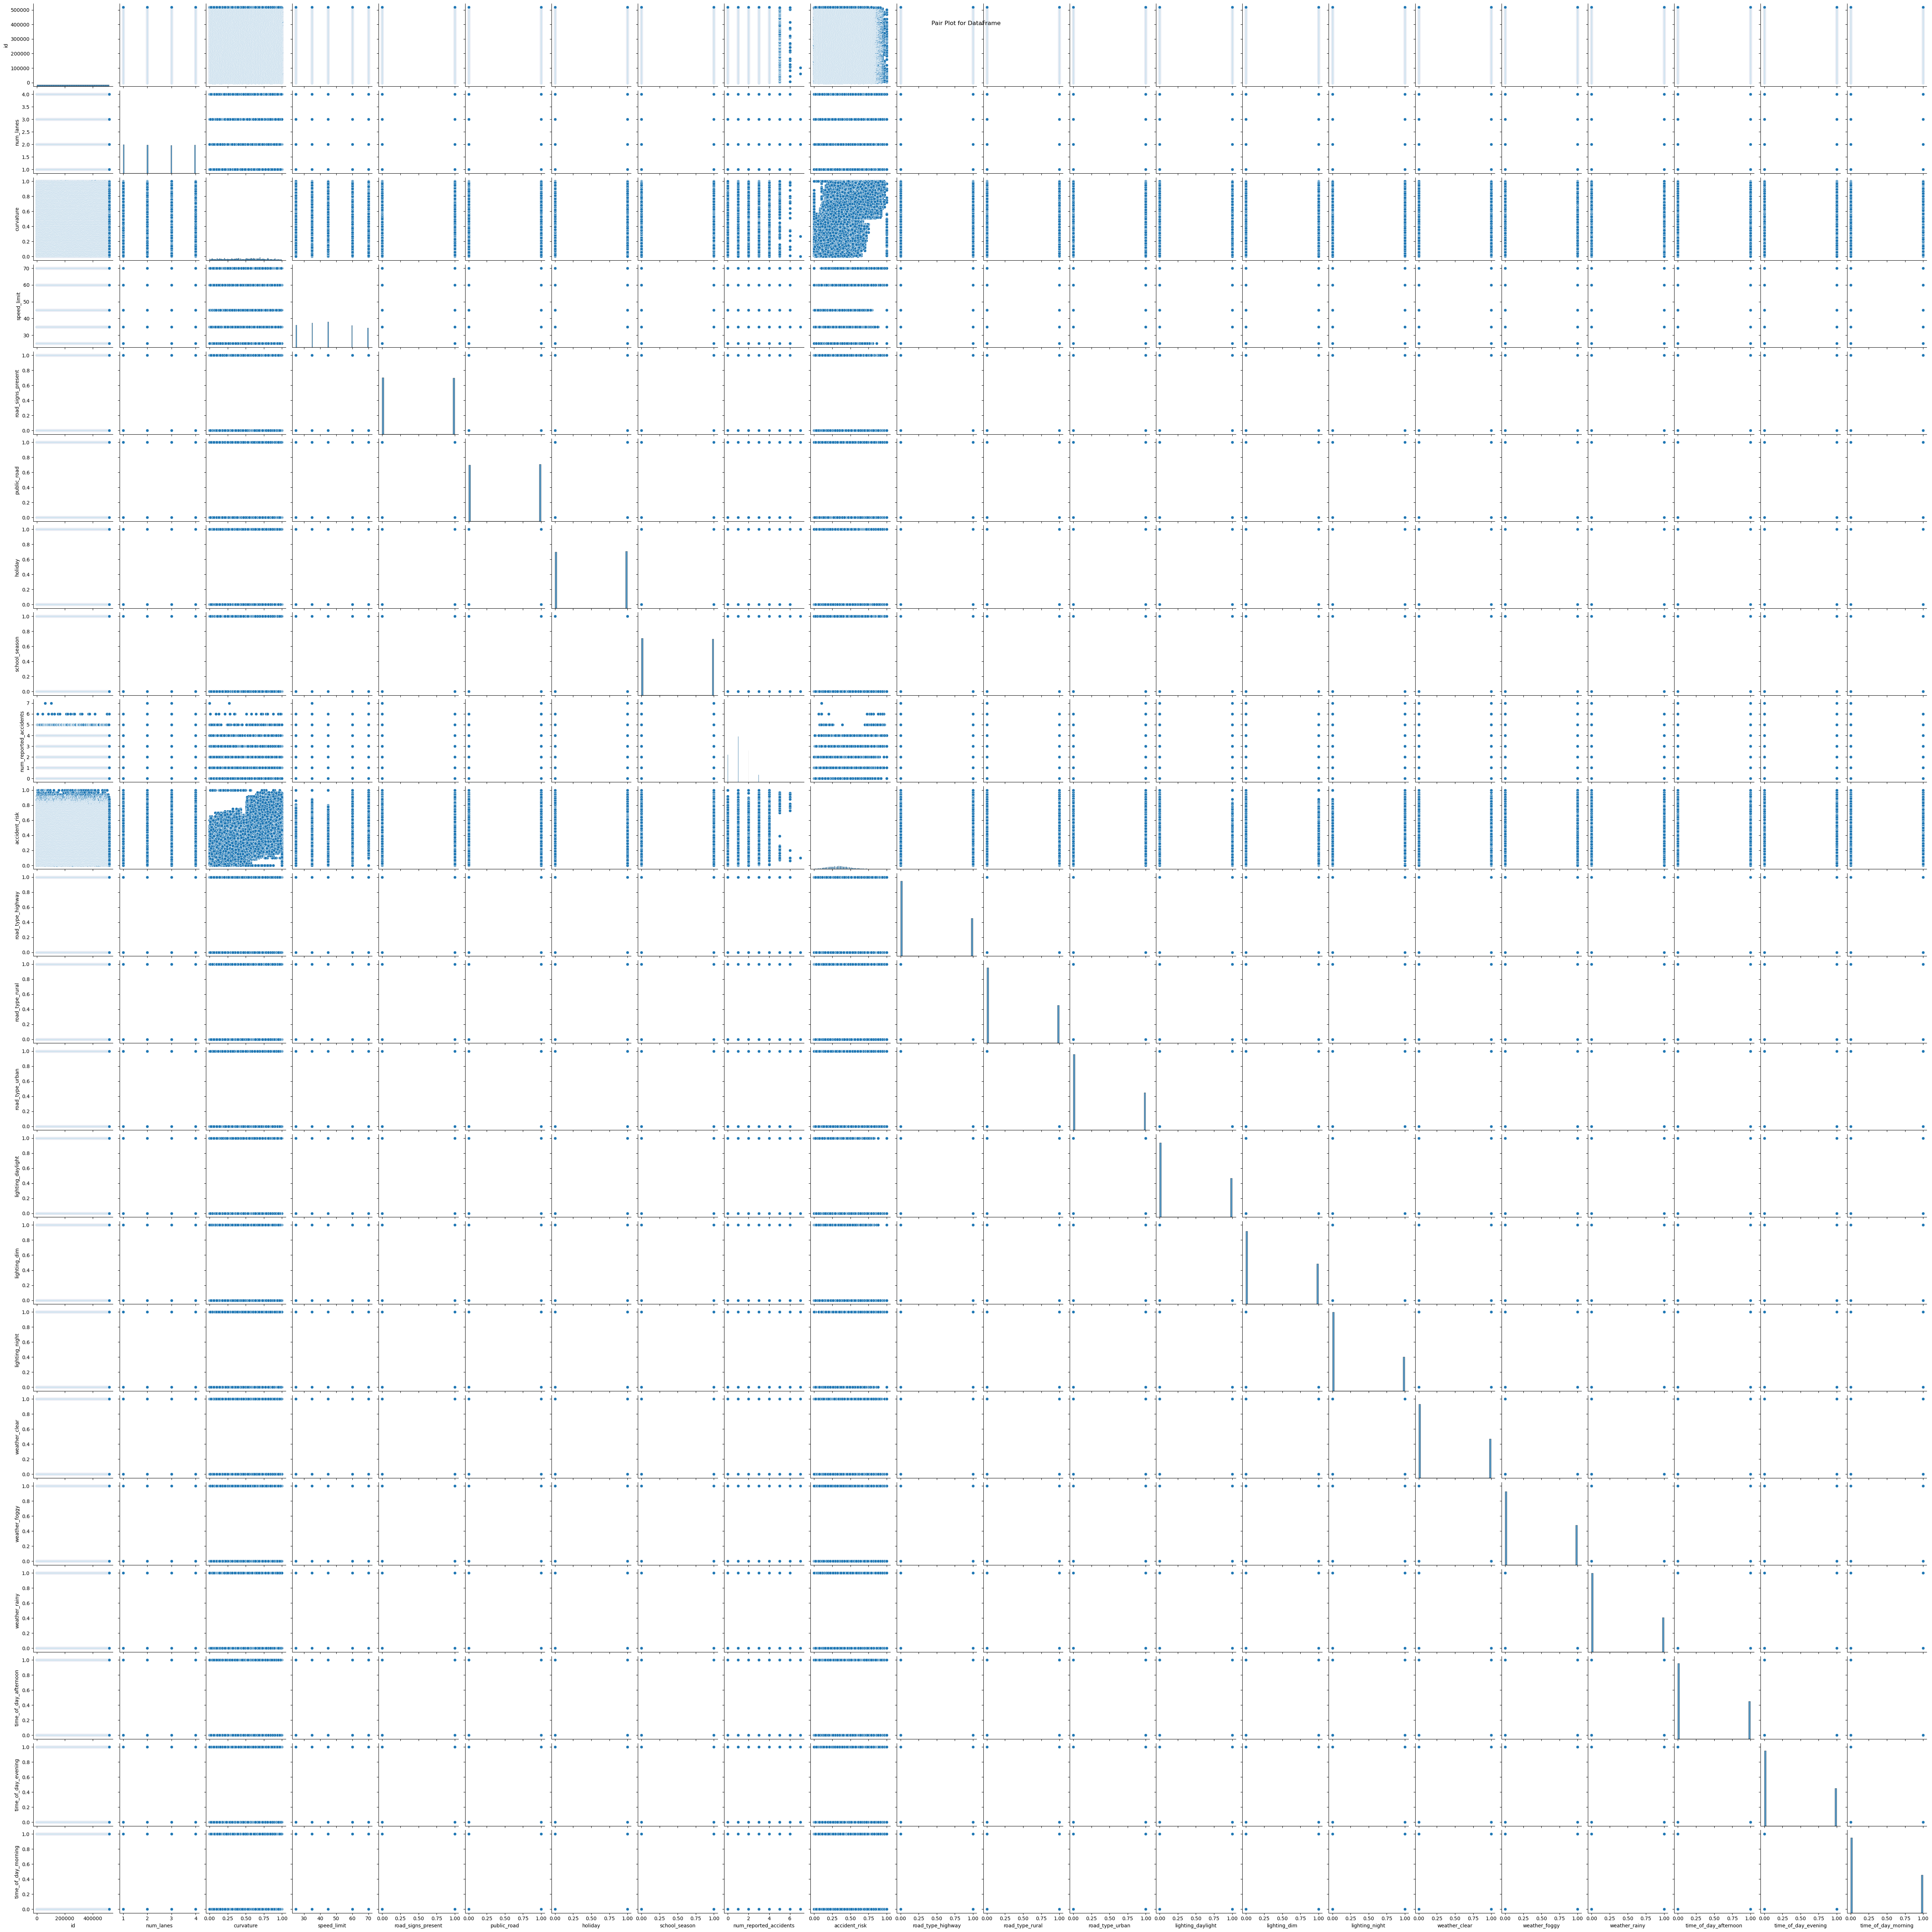

In [41]:
plt.figure(figsize=(10, 6))

sns.pairplot(train_encoded)

plt.suptitle('Pair Plot for DataFrame')
plt.show()

## Multivariate Analysis

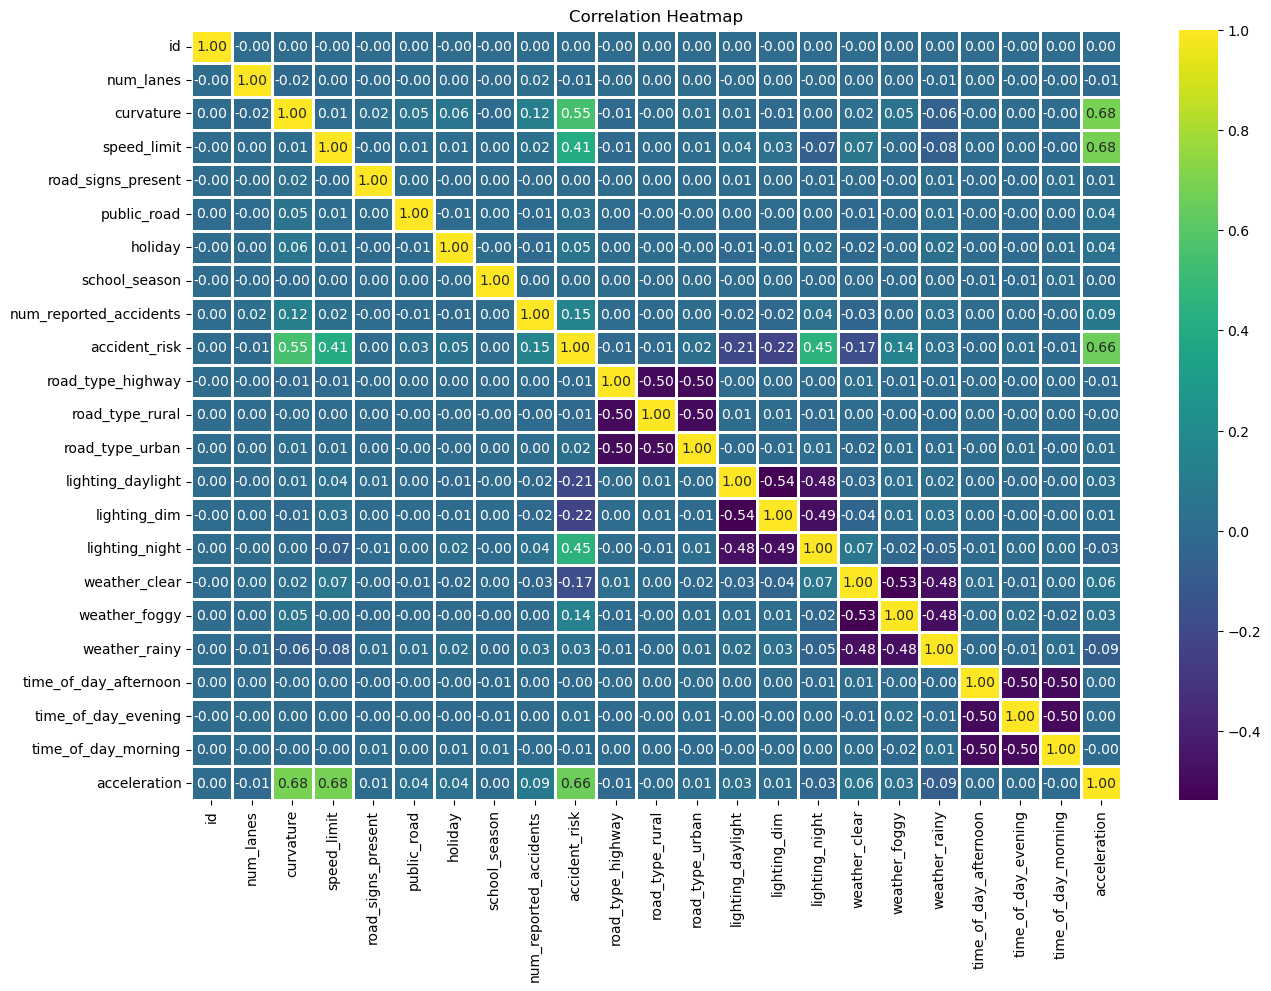

In [53]:
plt.figure(figsize=(15, 10))

sns.heatmap(train_encoded.corr(method = 'spearman', numeric_only=True), annot=True, fmt='.2f', cmap='viridis', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

The multivariate analysis indicates that accident risk tends to increase on curved roads, at higher speed limits, and under nighttime lighting conditions. Conversely, risk decreases in clear weather and under daylight or dim lighting. These relationships suggest that both road geometry and environmental visibility are key factors in accident occurrence.


## Feature engineering

I have decided to generate a new feature, lateral acceleration, based on the existing speed and curvature variables.

a = v^2/r = v^2 * curvature.  

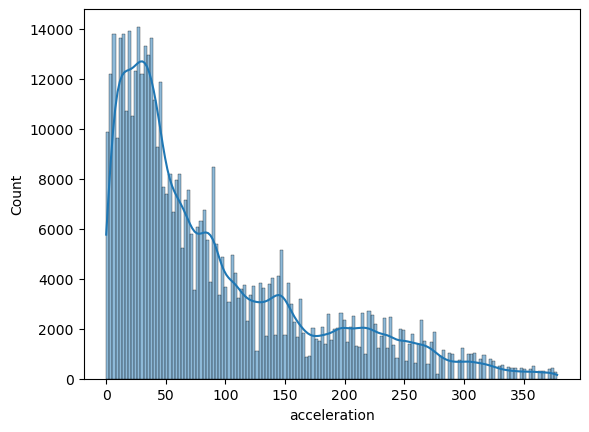

In [47]:
train_df['acceleration'] = ((train_df['speed_limit']/3.6) ** 2) * train_df['curvature']

sns.histplot(train_df, x = 'acceleration', kde=True)
plt.show()


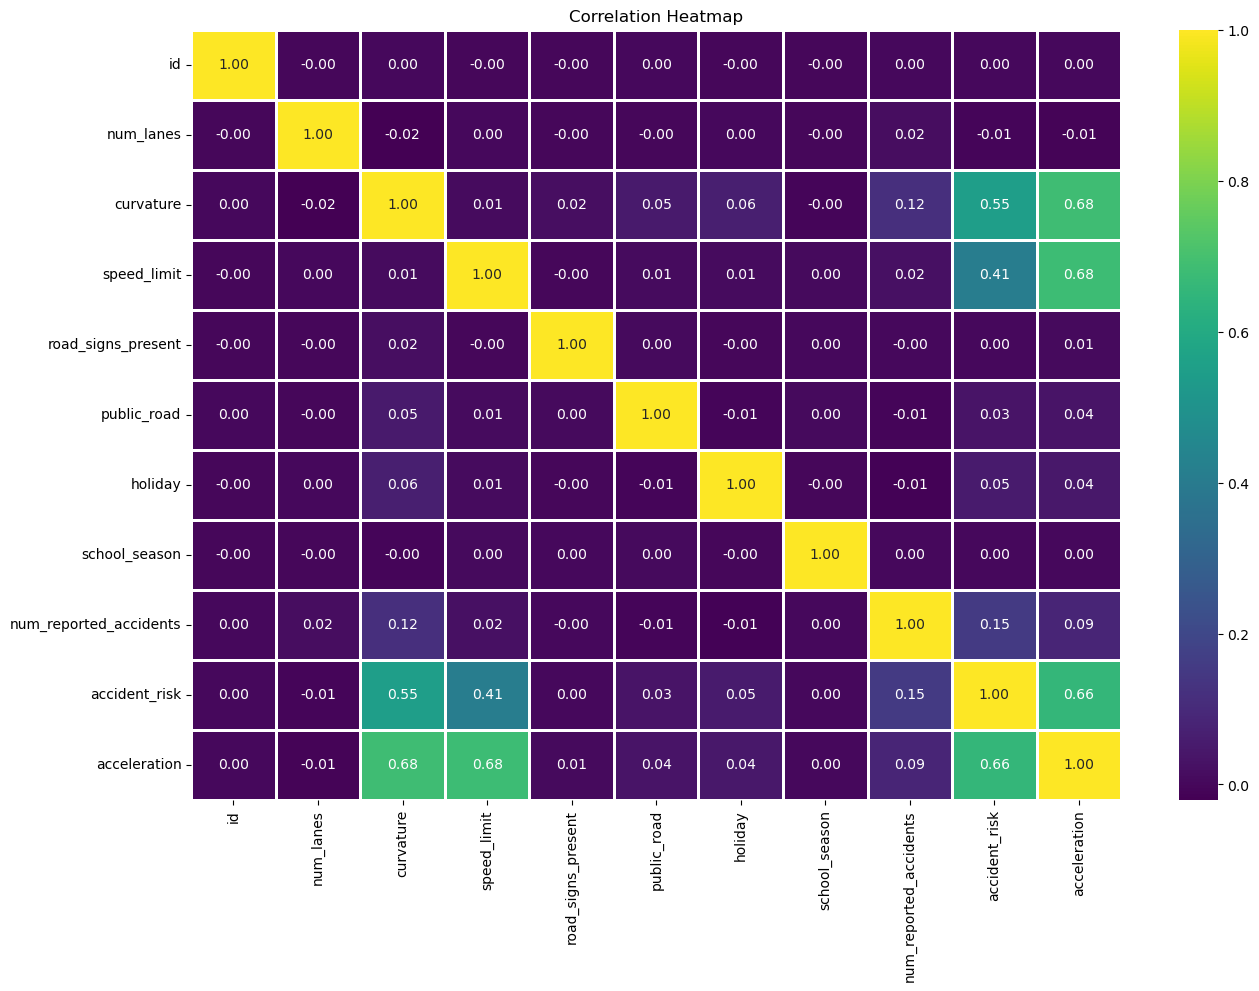

In [52]:
plt.figure(figsize=(15, 10))

sns.heatmap(train_df.corr(method = 'spearman', numeric_only=True), annot=True, fmt='.2f', cmap='viridis', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

So as we can see, acceleration has a very high correlation with the risk of an accident. 

## Training a FTTransformer

I could have tried many different architectures for this challenge, such as LightGBM, CatBoost, Random Forest, and others. However, I already have considerable experience with those models and wanted to explore something more interesting — transformers.

Transformer models are typically used to capture relationships in sequence-related tasks. However, when dealing with tabular data, each row can be viewed as a sequence of features, and the goal is to learn the relationships between them. The FT-Transformer is a transformer-based architecture specifically designed for tabular data.

Inspired by: https://www.kaggle.com/code/masatakasuzuki/ft-transformer-transformer-for-tabular-data




In [19]:

train_df = pd.read_csv('/Users/malev41/Desktop/NN/kaggle/road_accidents/data/train.csv')
train_df['acceleration'] = ((train_df['speed_limit']/3.6) ** 2) * train_df['curvature']

## Preprocessing 

### Scaling

The only thing we need to scale is the acceleration 

<Axes: xlabel='acceleration', ylabel='Count'>

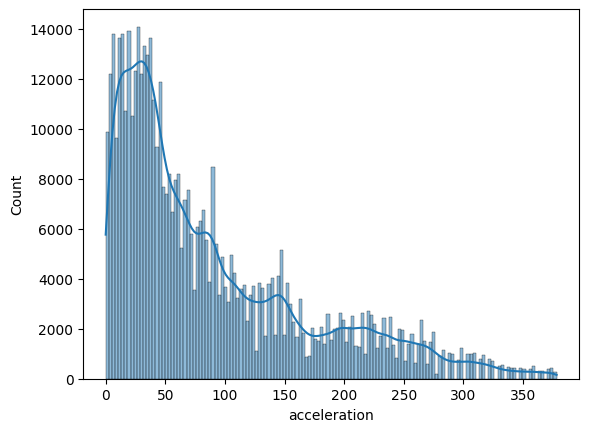

In [21]:
sns.histplot(data=train_df, x='acceleration', kde=True)

Since acceleration is strongly right-skewed, I choose to use Yeo–Johnson transformation

<Axes: xlabel='acceleration_yeojohnson', ylabel='Count'>

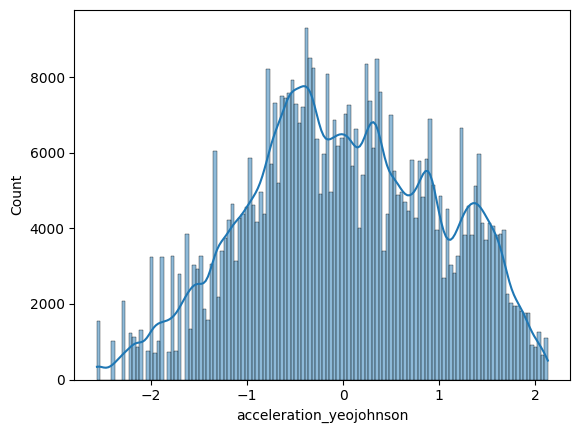

In [24]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson', standardize=True)
train_df['acceleration_yeojohnson'] = pt.fit_transform(train_df[['acceleration']])

sns.histplot(data=train_df, x='acceleration_yeojohnson', kde=True)

### Preparations for using FT-Transformer

In [26]:
categ_features = train_df.select_dtypes(exclude=['number']).columns.tolist()
print('Categorical features:', categ_features)
num_features = [col for col in train_df.select_dtypes(include=['number']).columns 
                if col not in ['id', 'accident_risk', 'acceleration']]
print('Numerical features:', num_features)
features = categ_features + num_features
target= 'accident_risk'

Categorical features: ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']
Numerical features: ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents', 'acceleration_yeojohnson']


### Split into train and validation datasets

In [31]:
train_data, val_data = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=44)



In [32]:
train_data.shape, val_data.shape

((465978, 16), (51776, 16))

### Transform to TF dataset

In [35]:
import numpy as np

train_dataset = df_to_dataset(train_data[features + [target]], target, shuffle=True, batch_size=256)
val_dataset = df_to_dataset(val_data[features + [target]], target, shuffle=False, batch_size=256)

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.